In [161]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../../code/')
import leakage
from pathlib import Path

# Load model

In [162]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')

In [163]:
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

## Define environment

In [164]:
model.reactions.EX_glc__D_e.lower_bound = -10
for r in model.exchanges:
    r.upper_bound = 1000

# Get leakage


In [165]:
exometabolites_folder = Path("../../data/e_coli/")
leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = 7)
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)

In [166]:
leakage_df

,Leakage (uM/h/OD),Leakage std
Metabolite,,
G6P,0.440616,0.015430
F6P,0.718007,0.033832
FBP,0.359004,0.014058
DHAP,0.627496,0.065091
GA3P,0.186804,0.014218
23PG,0.254953,0.023705
PEP,0.069823,0.006347
R5P,0.092261,0.004086
RU5P+X5P,0.041445,0.003663


In [167]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/e_coli/abbrev_to_id.csv', index_col=0)
leakage_df = leakage_df.join(mapping_df)


In [168]:
leakage_df.set_index('met id', inplace = True)

# Plot a cumulative distribution of shadow prices


In [169]:
solution = model.optimize()

In [170]:
print(model.summary())

Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.643700290691648

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00335         0   0.00%
      cl_e      EX_cl_e   0.00335         0   0.00%
 cobalt2_e EX_cobalt2_e 1.609E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004564         0   0.00%
     fe2_e     EX_fe2_e   0.01034         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1256         0   0.00%
     mg2_e     EX_mg2_e  0.005584         0   0.00%
     mn2_e     EX_mn2_e 0.0004448         0   0.00%
    mobd_e    EX_mobd_e 8.304E-05         0   0.00%
     nh4_e     EX_nh4_e     6.952         0   0.00%
     ni2_e     EX_ni2_e 0.0002079         0   0.00%
      o2_e      EX_o2_e      17.6         0   0.00%
      pi_e      EX_pi_e    0.6209         0   0.00%
     so4_e     EX_so4_e    0.1623         0   0.00%
     zn2_e     EX_zn2_e 0.0002195   

In [171]:
turnover_dict = {}
for m in model.metabolites:
    if m.compartment == 'c':
        total_flux = 0
        for r in m.reactions:
            flux_r = solution.fluxes[r.id]*r.get_coefficient(m.id)
            if flux_r > 0:
                total_flux += flux_r
        turnover_dict[m.id] = total_flux

In [172]:
sp = solution.shadow_prices

In [173]:
sp.sort_values(inplace=True)

In [174]:
model.metabolites.na1_c.elements

{'Na': 1}

In [175]:
met_ids =[]
sp_list = []
for m in model.metabolites:
    if m.compartment == 'c':
        if sp[m.id] <0:
            if turnover_dict[m.id] >0:
                if 'C' in m.elements.keys():
                    met_ids.append(m.id)
                    sp_list.append(sp[m.id])

In [176]:
selected_sp = pd.Series(sp_list, index = met_ids)

In [177]:
selected_sp.sort_values(inplace = True)

In [178]:
selected_sp[:20]

bmocogdp_c     -60.429075
bmoco1gdp_c    -60.181363
bmoco_c        -59.933651
mptamp_c       -30.214365
moco_c         -29.969386
pheme_c         -2.959709
sheme_c         -2.779527
dscl_c          -2.777315
scl_c           -2.776351
ppp9_c          -2.373381
pppg9_c         -2.342189
uppg3_c         -2.271847
hmbil_c         -2.271687
cpppg3_c        -2.269481
thmpp_c         -2.228439
fadh2_c         -2.115163
fad_c           -2.112711
kdo2lipid4_c    -1.583012
uaagmda_c       -1.548024
kdolipid4_c     -1.488672
dtype: float64

7.02208118035429
7.291604012368288
7.313688235394789
7.585027348892724
7.931925719056802
7.963547711623292
8.168018398859463
8.224240426412997
8.59647485189664
8.59806244648892
8.99701009030909
9.274957328132283
9.294973429011245
9.42417798642578
9.637805815626836
9.732622149351693
9.761478430718098
9.766510074372817
9.785765594857105
9.834773988662654
9.846791821812094
9.84908130031573
9.943419993582122
9.943670914511529
10.036959228443834
10.118938718288712
10.243790427964758
10.271411506691885
10.401291281070694
10.532211610848304
11.178882836053585
13.63666652537611


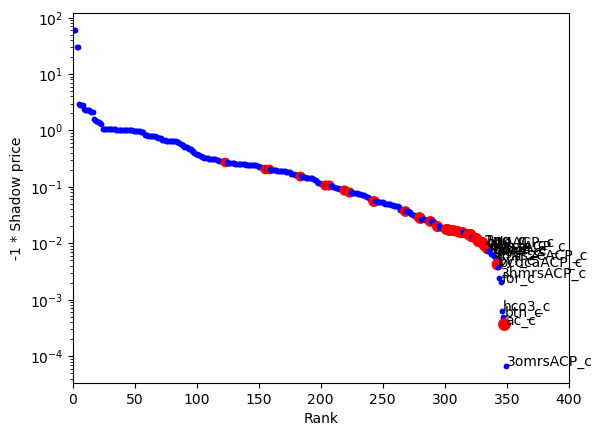

In [179]:
fig, ax = plt.subplots(1)
smax = leakage_df['Leakage (uM/h/OD)'].abs().max()
for i, (m_id, sp) in enumerate(selected_sp.iteritems()):
    met_id = m_id.replace('_c', '')
    try:
        leak_i = leakage_df.loc[met_id, "Leakage (uM/h/OD)"]
    except KeyError:
        leak_i = 0 
    sp_abs = np.abs(sp)
    if leak_i > 0:
        size = -1*np.log(sp_abs / smax)
        print(size)
        ax.scatter(i, sp_abs, s = 5*size, c = 'r')
    else:
        ax.scatter(i, sp_abs,s=10, c = 'b')
    
    if sp_abs < 1e-2:
        ax.annotate(m_id, (i+1, sp_abs))
#ax.scatter(np.arange(len(selected_sp)), np.abs(selected_sp), s = 10)
ax.set_yscale('log')
ax.set_xlim(0,400)
ax.set_ylabel('-1 * Shadow price')
ax.set_xlabel('Rank')
plt.savefig('Rank of shadow price ecoli knock outs.svg')

In [65]:
sp_neg = [x for x in sp_list if x < 0]
sp_pos = [x for x in sp_list if x > 0]

In [66]:
sp_neg = sorted(sp_neg)
sp_pos = sorted(sp_pos)

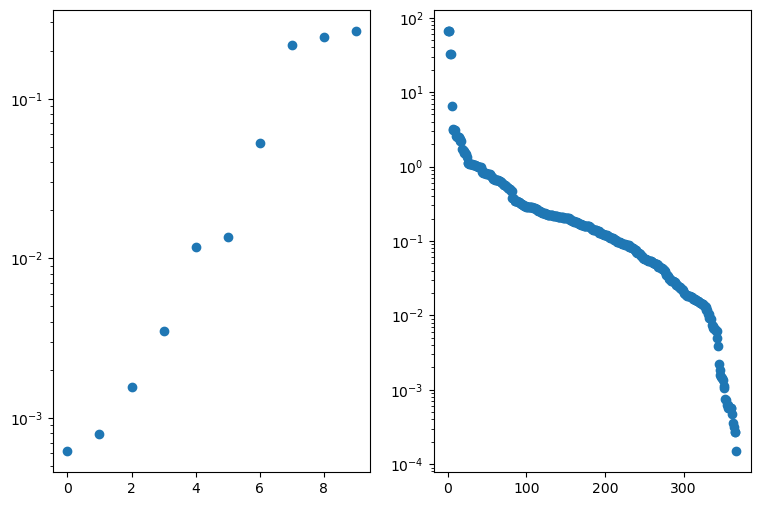

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 6))
ax1.scatter(np.arange(len(sp_pos)), sp_pos)
ax1.set_yscale('log')
ax2.scatter(np.arange(len(sp_neg)), np.abs(sp_neg))
ax2.set_yscale('log')